#Nhóm 4: phân tích đối tượng trong phòng thực hành
+ Thành viên:
  + Lý An - 19DH110830
  + Lạc Quốc Lan Linh - 19DH110769
  + Tăng Hoàng Triều - 19DH111102
  + Nguyễn Ngọc Kiều - 19DH110116

+ Dữ liệu:
  + Board(bảng): 147
  + Chair(ghế): 313
  + Laptop: 315
  + Table(bàn): 275

+ data: https://drive.google.com/drive/folders/1nxvBP8U-Sz5ixWnbhHoDKlyh16KNty1B?usp=share_link

# Import thư viện

In [ ]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn import decomposition
from keras.models import Sequential
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
import seaborn as sn; sn.set(font_scale=1.4)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Flatten
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Sequential
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.layers import Conv2D, Activation, MaxPooling2D, Input, Flatten, Dense
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/
%ls 'deep'

/content/drive/MyDrive
'full img'/  'full segment'/   img/   labels/


# Gán nhãn dữ liệu

In [ ]:
class_names = ['board', 'chair', 'laptop', 'table']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (224, 224)

# Load dữ liệu

In [ ]:
def load_data():
    datasets = ['/content/drive/MyDrive/deep/img','/content/drive/MyDrive/deep/labels']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
path = "/content/drive/MyDrive/deep"
img_dim = 224
image_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
mask_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)

train_image_generator = image_datagen.flow_from_directory(
        path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['full img'],
        batch_size = 32,
        seed=42,
        subset='training')
    
train_mask_generator = mask_datagen.flow_from_directory(
        path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['full segment'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='training')

val_image_generator = image_datagen.flow_from_directory(
        path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['full img'],
        batch_size = 32,
        seed=42,
        subset='validation')
    
val_mask_generator = mask_datagen.flow_from_directory(
        path,
        target_size=(img_dim, img_dim),
        class_mode = None,
        classes = ['full segment'],
        color_mode = 'grayscale',
        batch_size = 32,
        seed=42,
        subset='validation')

train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 840 images belonging to 1 classes.
Found 840 images belonging to 1 classes.
Found 209 images belonging to 1 classes.
Found 209 images belonging to 1 classes.


##Show thử nghiệm

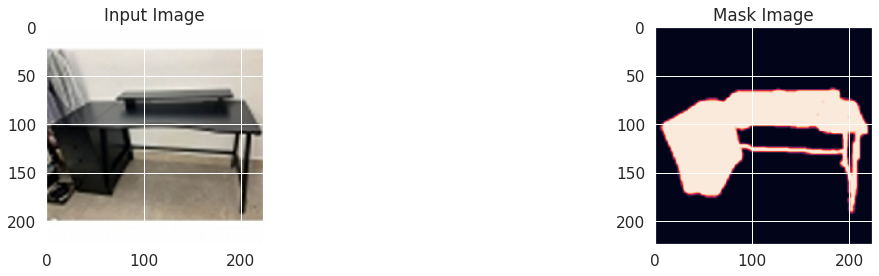

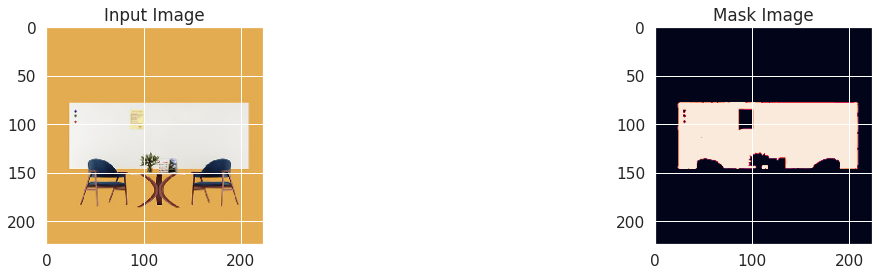

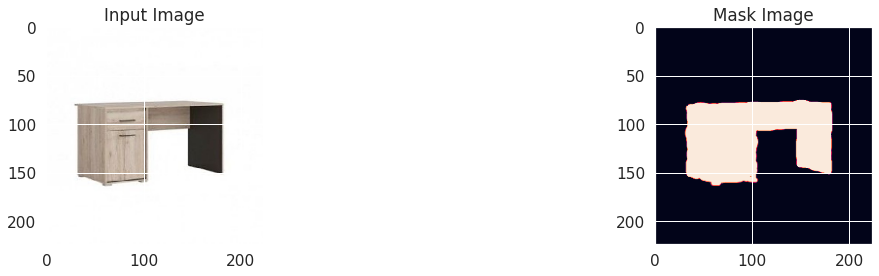

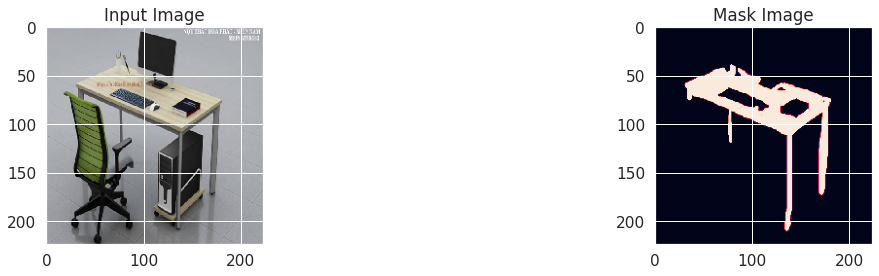

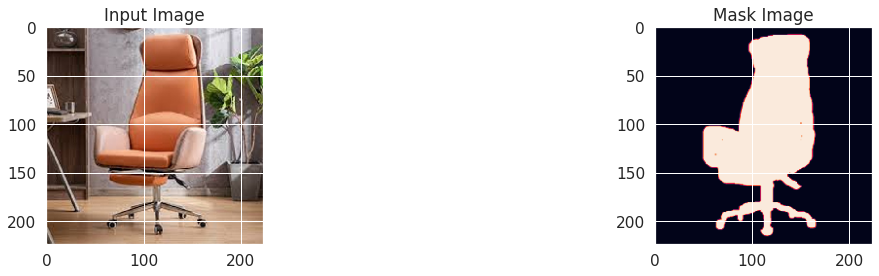

In [ ]:
n = 0
for i,m in train_generator:
    img,mask = i,m

    if n < 5:
        fig, axs = plt.subplots(1 , 2, figsize=(20,4))
        axs[0].imshow(img[0])
        axs[0].set_title('Input Image')
        axs[1].imshow(np.squeeze(mask[0]))
        axs[1].set_title('Mask Image')
        plt.show()
        n+=1
    else:
        break

## Train, test dữ liệu

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/drive/MyDrive/deep/img


100%|██████████| 315/315 [00:04<00:00, 75.69it/s]


Loading /content/drive/MyDrive/deep/labels


100%|██████████| 315/315 [00:01<00:00, 251.33it/s]


In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 1050
Number of testing examples: 1050
Each image is of size: (224, 224)


Nhận xét:
* Số ví dụ huấn luyện: 1050
* Số ví dụ thử nghiệm: 1050
* Mỗi ảnh có kích thước: (224, 244)

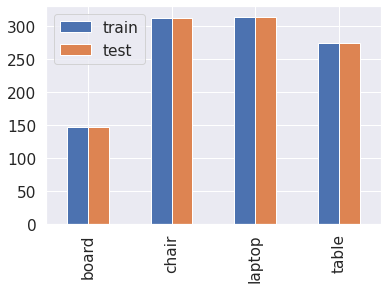

In [ ]:
_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

## Phần trăm từng loại trong dữ liệu

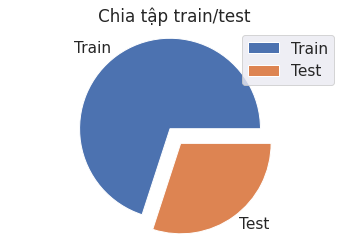

In [ ]:
y = np.array([70,30])

mylabels = ["Train", "Test"]
myexplode = [0.2, 0]
plt.pie(y, labels = mylabels,explode = myexplode)
plt.axis('equal')
plt.title('Chia tập train/test')
plt.legend()
plt.show()

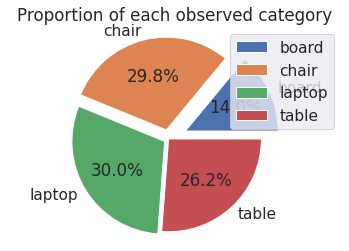

In [ ]:
plt.pie(train_counts,
        explode=(0.2, 0.1, 0.05, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.legend()
plt.title('Proportion of each observed category')
plt.show()

In [ ]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

## Hiển thị ảnh ngẫu nhiên và nhãn tương ứng

In [ ]:
def display_random_image(class_names, images, labels):
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

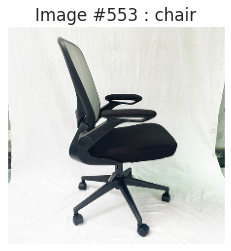

In [ ]:
display_random_image(class_names, train_images, train_labels)

## Một số ảnh ví dụ trong tập dữ liệu

In [ ]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

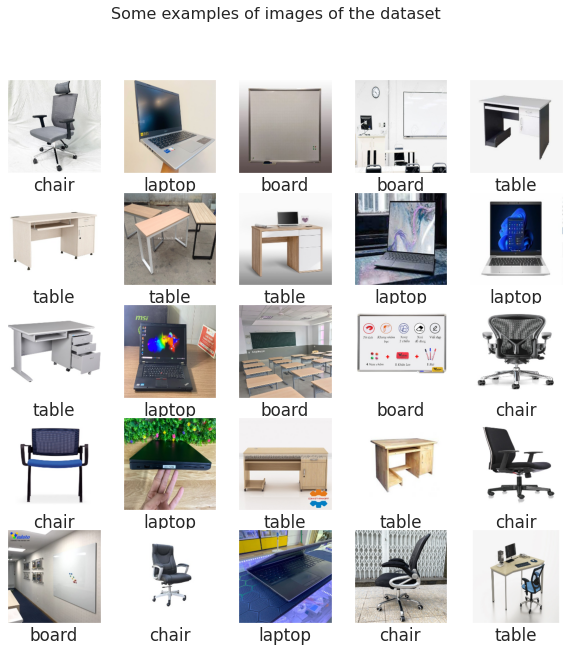

In [ ]:
display_examples(class_names, train_images, train_labels)

#CNN (Convolutional Neural Network)

In [ ]:
model = Sequential(name='cnn')
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))
model.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 96)       0       

In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_images, train_labels, batch_size=128, epochs=10, validation_split = 0.2)

Epoch 1/10
7/7 [==============================] - 9s 658ms/step - loss: 1.5775 - accuracy: 0.3155 - val_loss: 1.2787 - val_accuracy: 0.4571
Epoch 2/10
7/7 [==============================] - 2s 262ms/step - loss: 1.0890 - accuracy: 0.5560 - val_loss: 0.9124 - val_accuracy: 0.6286
Epoch 3/10
7/7 [==============================] - 2s 269ms/step - loss: 0.8005 - accuracy: 0.6762 - val_loss: 0.7948 - val_accuracy: 0.7000
Epoch 4/10
7/7 [==============================] - 2s 276ms/step - loss: 0.6232 - accuracy: 0.7679 - val_loss: 0.7366 - val_accuracy: 0.6571
Epoch 5/10
7/7 [==============================] - 2s 259ms/step - loss: 0.5423 - accuracy: 0.7905 - val_loss: 0.6740 - val_accuracy: 0.7476
Epoch 6/10
7/7 [==============================] - 2s 242ms/step - loss: 0.4540 - accuracy: 0.8393 - val_loss: 0.6538 - val_accuracy: 0.7810
Epoch 7/10
7/7 [==============================] - 2s 243ms/step - loss: 0.3510 - accuracy: 0.8726 - val_loss: 0.5338 - val_accuracy: 0.7952
Epoch 8/10
7/7 [====

## Biểu đồ Plot hiển thị loss & accuracy

Text(0.5, 1.0, 'Accuracy Curves')

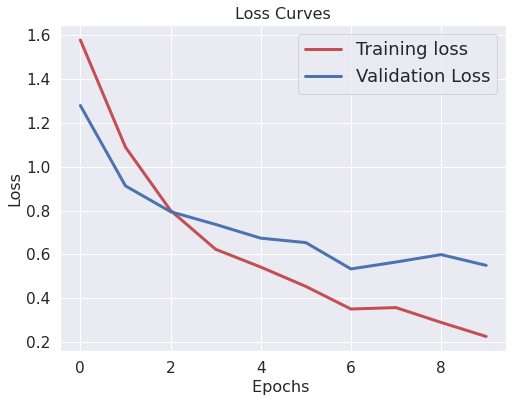

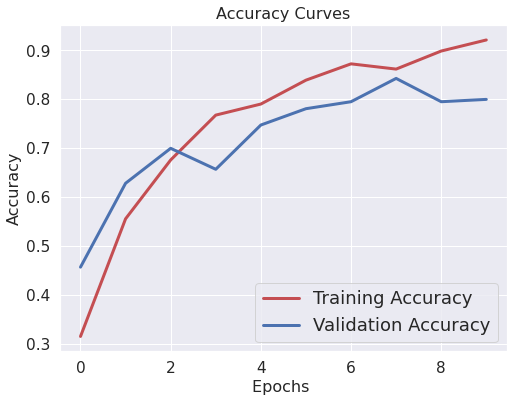

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
test_loss = model.evaluate(test_images, test_labels)

33/33 [==============================] - 1s 34ms/step - loss: 2.2674 - accuracy: 0.5714


## Kết quả cao nhất từ mô hình cnn

33/33 [==============================] - 1s 24ms/step


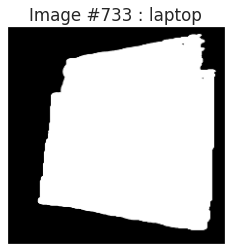

In [ ]:
predictions = model.predict(test_images)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

display_random_image(class_names, test_images, pred_labels)

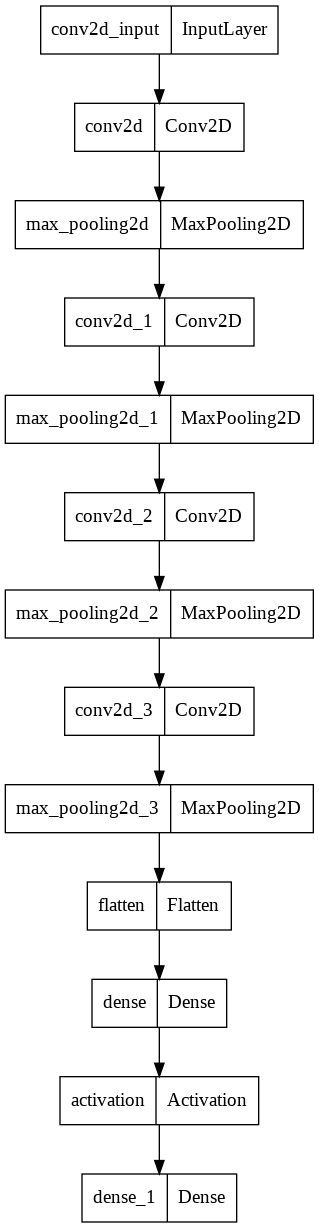

In [ ]:
plot_model(model, to_file='model.png')

## Một số ảnh được gán nhãn sai

In [ ]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels)

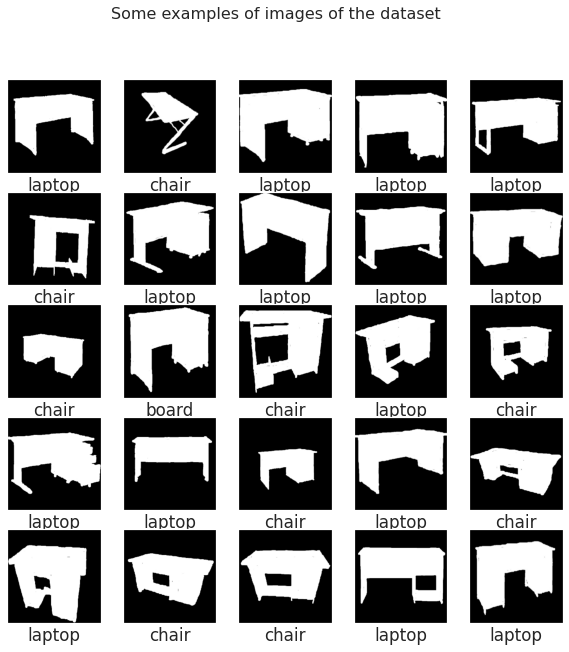

In [ ]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

## Ma trận nhầm lẫn (Confusion matrix)

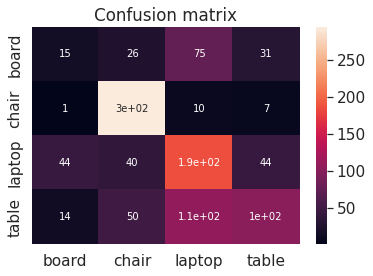

In [ ]:
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

##Feature extraction with VGG ImageNet

In [ ]:
model = VGG16(weights='imagenet', include_top=False)

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

33/33 [==============================] - 4s 136ms/step


In [ ]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [ ]:
pca = decomposition.PCA(n_components = 2)

X = train_features.reshape((n_train, x*y*z))
pca.fit(X)

C = pca.transform(X) # Représentation des individus dans les nouveaux axe
C1 = C[:,0]
C2 = C[:,1]

##PCA Projection

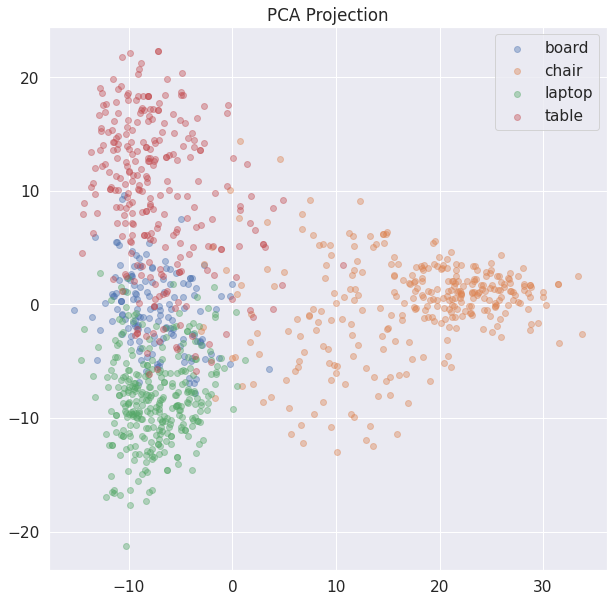

In [ ]:
### Figures
plt.subplots(figsize=(10,10))

for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000], C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")
plt.show()

In [ ]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (x, y, z)),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])
model2.summary()

model2.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_features, train_labels, batch_size=128, epochs=15, validation_split = 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 50)                1254450   
                                                                 
 dense_3 (Dense)             (None, 6)                 306       
                                                                 
Total params: 1,254,756
Trainable params: 1,254,756
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
7/7 [==============================] - 0s 33ms/step - loss: 1.5667 - accuracy: 0.5179 - val_loss: 0.2960 - val_accuracy: 0.8762
Epoch 2/15
7/7 [==============================] - 0s 13ms/step - loss: 0.2981 - accuracy: 0.8940 - val_loss: 0.1613 - val_accuracy: 0.9381
Epoch 3/15
7/7 [================

### biểu đồ Plot

Text(0.5, 1.0, 'Accuracy Curves')

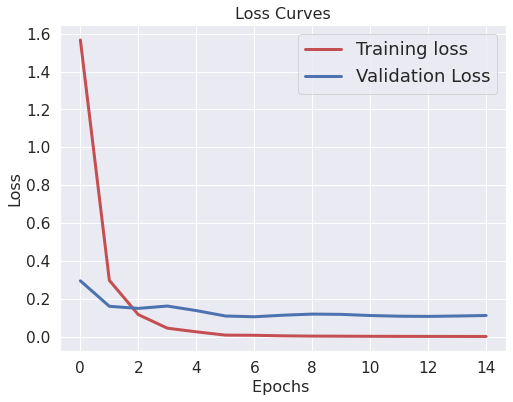

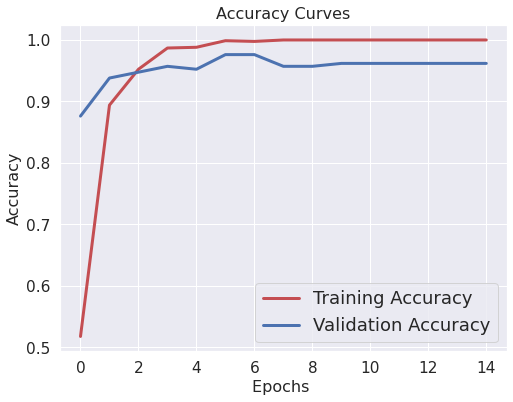

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history2.history['loss'],'r',linewidth=3.0)
plt.plot(history2.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(history2.history['accuracy'],'r',linewidth=3.0)
plt.plot(history2.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

##Ensemble Neural Networks

In [ ]:
test_loss = model2.evaluate(test_features, test_labels)

33/33 [==============================] - 0s 4ms/step - loss: 0.5037 - accuracy: 0.8190


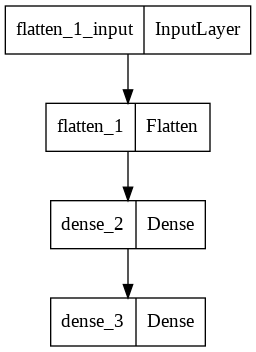

In [ ]:
plot_model(model2, to_file='model2.png')

In [ ]:
np.random.seed(seed=1997)
# Number of estimators
n_estimators = 10
# Proporition of samples to use to train each training
max_samples = 0.8

max_samples *= n_train
max_samples = int(max_samples)

In [ ]:
models = list()
random = np.random.randint(50, 100, size = n_estimators)

for i in range(n_estimators):
    
    # Model
    model = tf.keras.Sequential([ tf.keras.layers.Flatten(input_shape = (x, y, z)),
                                # One layer with random size
                                    tf.keras.layers.Dense(random[i], activation=tf.nn.relu),
                                    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
                                ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Store model
    models.append(model)

In [ ]:
histories = []
for i in range(n_estimators):
    # Train each model on a bag of the training data
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx], batch_size=128, epochs=10, validation_split = 0.1))

Epoch 1/10
6/6 [==============================] - 1s 36ms/step - loss: 1.9064 - accuracy: 0.4656 - val_loss: 0.3991 - val_accuracy: 0.8810
Epoch 2/10
6/6 [==============================] - 0s 13ms/step - loss: 0.3709 - accuracy: 0.8743 - val_loss: 0.2615 - val_accuracy: 0.9405
Epoch 3/10
6/6 [==============================] - 0s 12ms/step - loss: 0.1180 - accuracy: 0.9590 - val_loss: 0.1098 - val_accuracy: 0.9643
Epoch 4/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0489 - accuracy: 0.9828 - val_loss: 0.2122 - val_accuracy: 0.9286
Epoch 5/10
6/6 [==============================] - 0s 14ms/step - loss: 0.0418 - accuracy: 0.9841 - val_loss: 0.1854 - val_accuracy: 0.9405
Epoch 6/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0120 - accuracy: 0.9947 - val_loss: 0.1299 - val_accuracy: 0.9643
Epoch 7/10
6/6 [==============================] - 0s 15ms/step - loss: 0.0124 - accuracy: 0.9974 - val_loss: 0.1270 - val_accuracy: 0.9643
Epoch 8/10
6/6 [===========

In [ ]:
predictions = []
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))
    
predictions = np.array(predictions)
predictions = predictions.sum(axis = 0)
pred_labels = predictions.argmax(axis=1)

33/33 [==============================] - 0s 2ms/step


In [ ]:
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8247619047619048


##Pretrain with VGG16

In [ ]:
model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

In [ ]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

33/33 [==============================] - 4s 125ms/step


In [ ]:
model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0)
layer_input = Input(shape = (14, 14, 512))

x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(6,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

In [ ]:
new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 14, 14, 512)]     0         
                                                                 
 block5_conv1 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv2 (Conv2D)       multiple                  2359808   
                                                                 
 block5_conv3 (Conv2D)       multiple                  2359808   
                                                                 
 block5_pool (MaxPooling2D)  multiple                  0         
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 64)          294976    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 2, 2, 64)         0   

In [ ]:
history3 = new_model.fit(train_features, train_labels, batch_size=128, epochs=20, validation_split = 0.2)

Epoch 1/20
7/7 [==============================] - 3s 296ms/step - loss: 2.2509 - accuracy: 0.4107 - val_loss: 3.3816 - val_accuracy: 0.2000
Epoch 2/20
7/7 [==============================] - 1s 148ms/step - loss: 1.8674 - accuracy: 0.4774 - val_loss: 1.1790 - val_accuracy: 0.4571
Epoch 3/20
7/7 [==============================] - 1s 133ms/step - loss: 0.8092 - accuracy: 0.6940 - val_loss: 0.5147 - val_accuracy: 0.8095
Epoch 4/20
7/7 [==============================] - 1s 151ms/step - loss: 0.4216 - accuracy: 0.8488 - val_loss: 0.3250 - val_accuracy: 0.8714
Epoch 5/20
7/7 [==============================] - 1s 154ms/step - loss: 0.2297 - accuracy: 0.8929 - val_loss: 0.2803 - val_accuracy: 0.9048
Epoch 6/20
7/7 [==============================] - 1s 124ms/step - loss: 0.1107 - accuracy: 0.9512 - val_loss: 0.2556 - val_accuracy: 0.9095
Epoch 7/20
7/7 [==============================] - 1s 124ms/step - loss: 0.0574 - accuracy: 0.9798 - val_loss: 0.3304 - val_accuracy: 0.9143
Epoch 8/20
7/7 [====

### Biểu đồ Plot

Text(0.5, 1.0, 'Accuracy Curves')

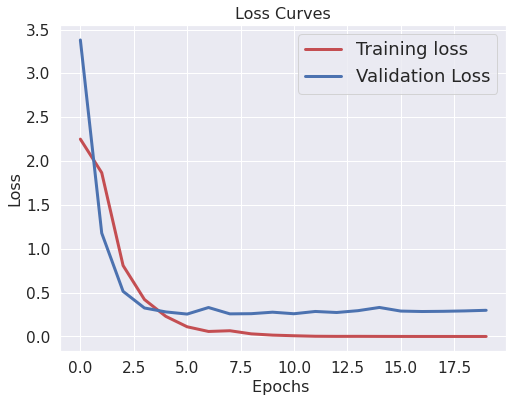

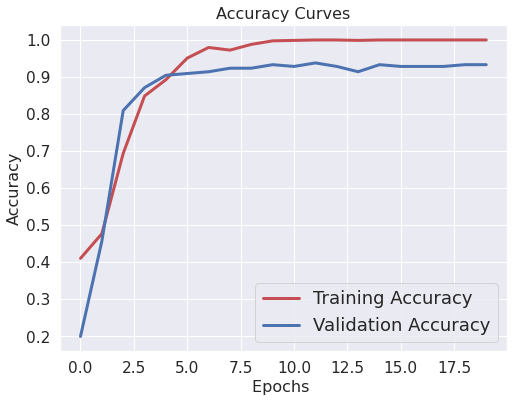

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history3.history['loss'],'r',linewidth=3.0)
plt.plot(history3.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(history3.history['accuracy'],'r',linewidth=3.0)
plt.plot(history3.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
predictions = new_model.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

33/33 [==============================] - 1s 14ms/step
Accuracy : 0.7847619047619048


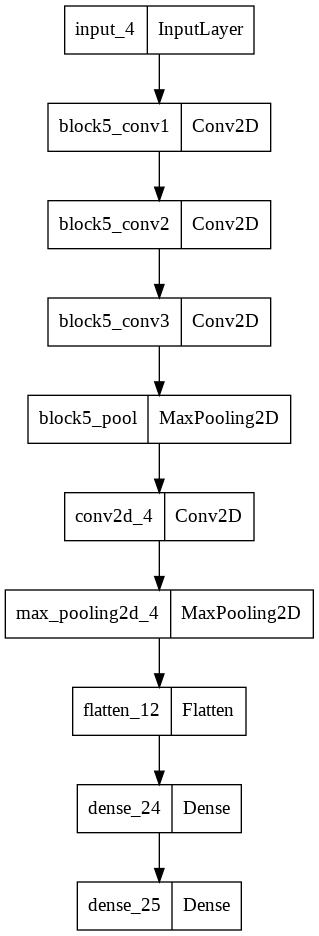

In [ ]:
plot_model(new_model, to_file='new_mode.png')

#MLP (Multi-layer Perceptron)

In [ ]:
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [ ]:
model = Sequential(name="mlp")
model.add(Flatten(input_shape =(224, 224, 3)))
model.add(tf.keras.layers.Dense(256, activation='relu' ))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))
model.summary()

Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 150528)            0         
                                                                 
 dense_26 (Dense)            (None, 256)               38535424  
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dense_29 (Dense)            (None, 4)                 260       
                                                                 
Total params: 38,576,836
Trainable params: 38,576,836
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='sgd',loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images,train_labels, batch_size=128, epochs=20,validation_data =(train_images,train_labels) )

Epoch 1/20
9/9 [==============================] - 2s 145ms/step - loss: 18.1302 - accuracy: 0.2467 - val_loss: 1.7427 - val_accuracy: 0.1410
Epoch 2/20
9/9 [==============================] - 1s 84ms/step - loss: 1.4779 - accuracy: 0.2562 - val_loss: 1.3258 - val_accuracy: 0.2962
Epoch 3/20
9/9 [==============================] - 1s 82ms/step - loss: 1.3120 - accuracy: 0.3105 - val_loss: 1.2927 - val_accuracy: 0.3933
Epoch 4/20
9/9 [==============================] - 1s 81ms/step - loss: 1.3173 - accuracy: 0.3781 - val_loss: 1.3041 - val_accuracy: 0.3086
Epoch 5/20
9/9 [==============================] - 1s 82ms/step - loss: 1.3077 - accuracy: 0.3000 - val_loss: 1.3208 - val_accuracy: 0.2962
Epoch 6/20
9/9 [==============================] - 1s 84ms/step - loss: 1.3029 - accuracy: 0.3095 - val_loss: 1.3987 - val_accuracy: 0.2971
Epoch 7/20
9/9 [==============================] - 1s 84ms/step - loss: 1.3044 - accuracy: 0.3324 - val_loss: 1.2682 - val_accuracy: 0.3486
Epoch 8/20
9/9 [=========

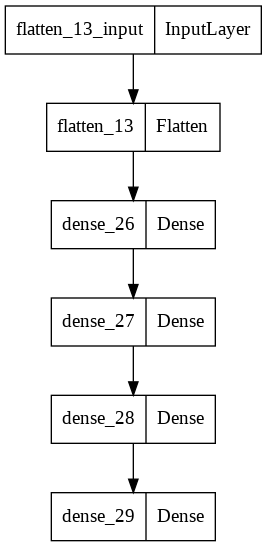

In [ ]:
plot_model(model, to_file='model.png')

In [ ]:
[test_loss, test_acc] = model.evaluate(test_images, test_labels)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

33/33 [==============================] - 0s 12ms/step - loss: 1.5597 - accuracy: 0.2114
Evaluation result on Test Data : Loss = 1.5597074031829834, accuracy = 0.21142856776714325


Text(0.5, 1.0, 'Accuracy Curves')

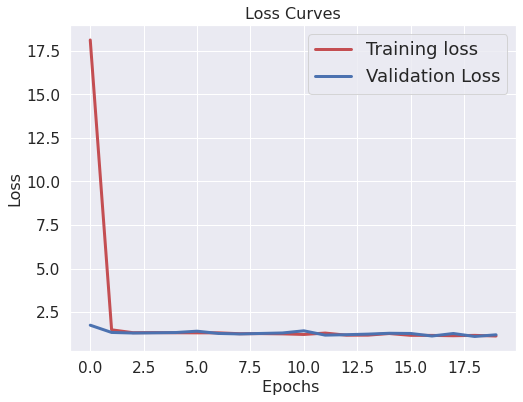

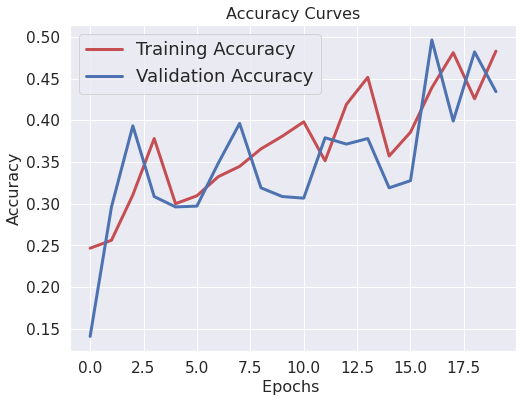

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

33/33 [==============================] - 0s 10ms/step


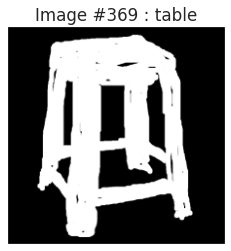

In [ ]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
rounded_labels= np.argmax(test_labels, axis=1)
display_random_image(class_names, test_images, pred_labels)

In [ ]:
from sklearn.metrics import classification_report
print("Confusion Matrix:")
print(confusion_matrix(rounded_labels, pred_labels))
print("="*80)
print("Bảng hiệu năng:")
print(classification_report(rounded_labels, pred_labels, target_names=class_names))

Confusion Matrix:
[[  1  32  26  88]
 [  2  91   2 218]
 [  2  37  30 246]
 [  1 153  21 100]]
Bảng hiệu năng:
              precision    recall  f1-score   support

       board       0.17      0.01      0.01       147
       chair       0.29      0.29      0.29       313
      laptop       0.38      0.10      0.15       315
       table       0.15      0.36      0.22       275

    accuracy                           0.21      1050
   macro avg       0.25      0.19      0.17      1050
weighted avg       0.26      0.21      0.19      1050



## Pretrain with Resnet50

In [ ]:
pretrained_base_ResNet50 = tf.keras.applications.ResNet50(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling='avg',
    classes=1000,
)

In [ ]:
model = keras.Sequential([
    pretrained_base_ResNet50,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
    ])

In [ ]:
model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_14 (Flatten)        (None, 1000)              0         
                                                                 
 dense_30 (Dense)            (None, 128)               128128    
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 4)                 260       
                                                                 
Total params: 25,773,356
Trainable params: 25,720,236
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
history = model.fit(train_images,train_labels,epochs=30,validation_data =(train_images,train_labels),
            validation_freq=1,
            verbose=1,
             )

Epoch 1/30
33/33 [==============================] - 23s 487ms/step - loss: 1.2479 - accuracy: 0.6886 - val_loss: 1.5016 - val_accuracy: 0.3000
Epoch 2/30
33/33 [==============================] - 13s 399ms/step - loss: 1.1261 - accuracy: 0.5533 - val_loss: 1.6383 - val_accuracy: 0.2981
Epoch 3/30
33/33 [==============================] - 13s 402ms/step - loss: 0.9617 - accuracy: 0.6305 - val_loss: 1.9648 - val_accuracy: 0.2981
Epoch 4/30
33/33 [==============================] - 13s 400ms/step - loss: 0.9365 - accuracy: 0.6352 - val_loss: 1.9216 - val_accuracy: 0.2981
Epoch 5/30
33/33 [==============================] - 13s 401ms/step - loss: 0.8506 - accuracy: 0.6619 - val_loss: 1.6299 - val_accuracy: 0.3000
Epoch 6/30
33/33 [==============================] - 13s 402ms/step - loss: 0.7712 - accuracy: 0.6886 - val_loss: 1.6513 - val_accuracy: 0.3000
Epoch 7/30
33/33 [==============================] - 13s 404ms/step - loss: 0.6885 - accuracy: 0.7324 - val_loss: 1.5599 - val_accuracy: 0.1695

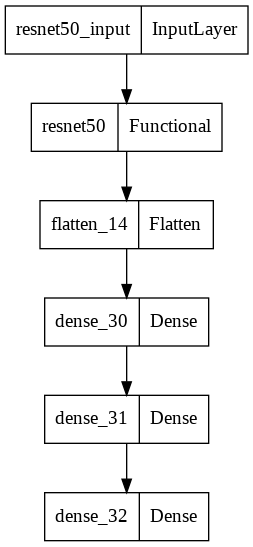

In [ ]:
plot_model(model, to_file='model.png')

### Biểu đồ Plot

Text(0.5, 1.0, 'Accuracy Curves')

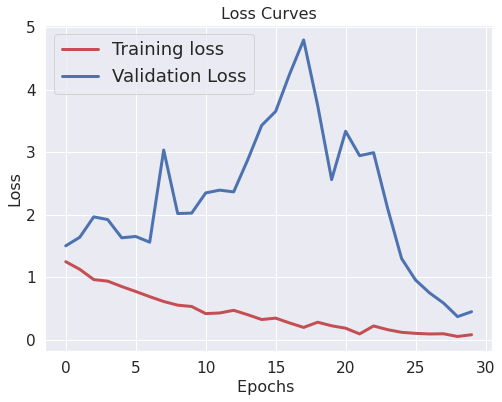

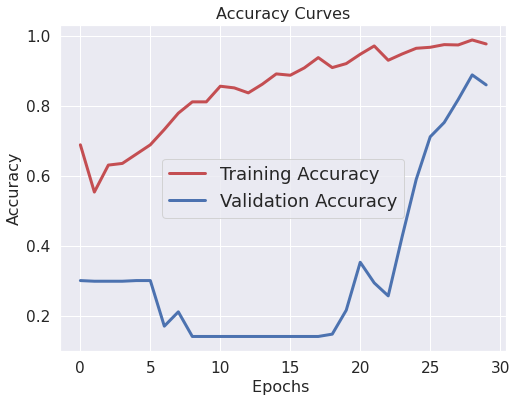

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

In [ ]:
[test_loss, test_acc] = model.evaluate(test_images, test_labels)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))

33/33 [==============================] - 3s 96ms/step - loss: 1.3151 - accuracy: 0.6038
Evaluation result on Test Data : Loss = 1.3150867223739624, accuracy = 0.6038095355033875


#Kết thúc quá trình thực nghiệm